In [1]:
%load_ext autoreload
%autoreload 2

# 1. Importing Libraries 

In [2]:
import os, sys, pickle
from pathlib import Path

#dir_p = Path().resolve() 
#dir_path = os.path.dirname(os.path.abspath(os.curdir))
#os.chdir(dir_path)

dir_p = Path().resolve() 


from agrid.grid import Grid


import pandas as pd

import re
import copy

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

from scipy import stats, interpolate, spatial, io
from scipy.ndimage import gaussian_filter, median_filter
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import Arc 
import cartopy.crs as ccrs

import pyproj as proj
import rasterio


from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing
import numba as nb
from numba import jit

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestRegressor

from skopt.space import Real, Categorical, Integer

from sklearn.metrics import make_scorer , r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import SCORERS


from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.compose import ColumnTransformer

from sklearn.compose import make_column_selector as selector


define constants and dcitionaries to easy looping

In [3]:
# constanst

#parent directory

dir_p = Path().resolve() 

#constants
km = 1000
milli = 0.001
micro = 0.000001

# fig size for presentation
fig_pres_small = (4,3)

fig_pres_small_cbar = (4,2)
#aspect ratio
fig_pres_large = (16,9)



# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

World = Grid(res=[0.2, 0.2], up=world_lat_max, down=world_lat_min)

# africa grid

Africa =    Grid(res=[0.2, 0.2],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)

# africa grid low resolution 50 x 50 km

Africa_50 =    Grid(res=[0.5, 0.5],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)


#dictionary of all grids

grids = {}

grids['Afr'] = Africa
grids['Afr_50'] = Africa_50
grids['World'] = World


In [4]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

In [5]:
# to ease looping with dictionaries

regions_a_a5 = [ 'Afr','Afr_50' ]

regions_w_a = [ 'World' ,'Afr',]
regions_w_aus = [ 'World' ,'Aus',]


regions_w_a_a5 = [ 'World' ,'Afr', 'Afr_50']


regions_Total = ['World' ,'Afr', 'Afr_50',]


# raster exenets to adjust map
raster_extent_Afr = [grids['Afr'].extent[0], grids['Afr'].extent[1], grids['Afr'].extent[3], grids['Afr'].extent[2]]
raster_extent_Afr_50 = [grids['Afr_50'].extent[0], grids['Afr_50'].extent[1], grids['Afr_50'].extent[3], grids['Afr_50'].extent[2]]
raster_extent_World = [grids['World'].extent[0], grids['World'].extent[1], grids['World'].extent[3], grids['World'].extent[2]]

# to correct plot maps
raster_extents = {}

raster_extents['Afr'] = raster_extent_Afr
raster_extents['Afr_50'] = raster_extent_Afr_50
raster_extents['World'] = raster_extent_World


# list of latitudes and longitudes
lon_dict = {}
lat_dict = {}

lon_dict['Afr'] = [afr_lon_min, afr_lon_max]
lon_dict['Afr_50'] = [afr_lon_min, afr_lon_max]
lon_dict['World'] = [world_lon_min, world_lon_max]

lat_dict['Afr'] = [afr_lat_min, afr_lat_max]
lat_dict['Afr_50'] = [afr_lat_min, afr_lat_max]
lat_dict['World'] = [world_lat_min, world_lat_max]


print('terminated')

terminated


In [6]:
obs = pd.DataFrame()


''' 
obs['REF_n'] = [ 'MOHO','LAB', 'RHO_C', 'SV', 'PV', 'CTD',
             'RHO_L', 'DEM', 
                'VOLC_DIST_W', 'A_MEDIAN_W', 'FA', 'SI','LITH_MANTLE', 
                'EMAG2_CLASS', 'GEOID', 'BG',
              'GLIM']'''



obs['OBS_REF_IDW'] = ['CTD_IDW' ,  'SI_IDW',"LAB_IDW", "MOHO_IDW",
            "SV_IDW","PV_IDW", 
            'GEOID_IDW','FA_IDW','DEM','BG_IDW', 'EMAG2_CLASS',
                   'RHO_L_IDW', 'RHO_C_IDW', 
                  'VOLC_DIST_W', 'REG', 'GLIM']



obs['OBS_REF_LN'] = ['CTD_LN' ,  'SI_LN',"LAB_LN", "MOHO_LN",
            "SV_LN","PV_LN", 
            'GEOID_LN','FA_LN','DEM','BG_LN', 'EMAG2_CLASS',
                  'RHO_L_LN', 'RHO_C_LN', 
                      'VOLC_DIST_W', 'REG', 'GLIM']
  
     
# Labels for plots etc
obs['LABELS'] = ['CTD',  'Shape index', 'LAB depth', 'Moho depth', 
                'S$_V$ 150km', 'P$_V$ 150km', 
                'Geoid', 'Free air', 'DEM', 'Bouguer', 'Mag.', 
                'Lith. ρ', 'Crust ρ',  
                 'Volcano d.', 'GliM', 'REG', ]  
    
    
# 'vp/vs'
# Units to display in plots etc
obs['UNITS'] = ['km',  'si', 'km', 'km',
             '$\delta$ v_s %','$\delta$ v_p %', 
             'm', 'mGal', 'm', 'mGal',  'f(nT)', 
                 'kg/m$^3$', 'kg/m$^3$',
                'km',  'class', 'class']
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs['V_RANGE'] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,15),]
    



#new_index = [4,3,15,6,7,0,14,10,16,17,9, 2,1,5,13,12, 8,11,]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

#obs = obs.reindex(new_index)

obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 12
print(obs)

n_obs = len(obs)

obs_dict = obs.to_dict(orient='records')



    OBS_REF_IDW   OBS_REF_LN       LABELS        UNITS      V_RANGE        CMAPS
0       CTD_IDW       CTD_LN          CTD           km      (0, 50)  <matplot...
1        SI_IDW        SI_LN  Shape index           si      (-1, 1)  <matplot...
2       LAB_IDW       LAB_LN    LAB depth           km     (0, 300)  <matplot...
3      MOHO_IDW      MOHO_LN   Moho depth           km     (15, 60)  <matplot...
4        SV_IDW        SV_LN  S$_V$ 150km  $\delta$...  (-0.075,...  <matplot...
5        PV_IDW        PV_LN  P$_V$ 150km  $\delta$...  (-0.02, ...  <matplot...
6     GEOID_IDW     GEOID_LN        Geoid            m    (-45, 45)  <matplot...
7        FA_IDW        FA_LN     Free air         mGal  (-100, 100)  <matplot...
8           DEM          DEM          DEM            m  (-2200, ...  <matplot...
9        BG_IDW        BG_LN      Bouguer         mGal  (-100, 100)  <matplot...
10  EMAG2_CLASS  EMAG2_CLASS         Mag.        f(nT)  (-0.4, 0.4)  <matplot...
11    RHO_L_IDW     RHO_L_LN

In [8]:

target = 'heat-flow (mW/m2)'
coord = ['lon', 'lat']
grid_index = ['grid_index']


#######

features_ex_ln = []
features_ghf_ln = []



features_ln = obs['OBS_REF_LN'].tolist()



in_features_ln = set(features_ln)

features_ex_ln = copy.deepcopy(features_ln)
features_ex_ln.extend(coord)
features_ex_ln.extend(grid_index)

features_ex_ln.append(target)

features_ghf_ln = copy.deepcopy(features_ln)
features_ghf_ln.append(target)




# 3. Hyperparameters tuning

In [ ]:

regressor_label = 'RFR'
kfold = 10
n_iter =100



file_labels =[ f'NOD_LN_ra', f'OD_LN_ra', 
              f'NOD_LN_rab',  f'OD_LN_rab',]

# param distribution
n_estimators      = np.arange(100, 700,50)
max_features = Categorical(['log2', 'sqrt'])
#the maximum number of features Random Forest is allowed to try in individual tree

bootstrap    = Categorical([True, False]) # deafult is false for extra trees True for randomforest
criterion    = Categorical(['squared_error', 'absolute_error' ])

# updated param distribution
#n_estimators      = Integer(150, 500)#  BEST 100

max_depth         =  Integer(5,50)  # best 50
min_samples_split =  Integer(2,50) 
min_samples_leaf  =  Integer(1,30) 



hyperparameters = {}

random_state = 42

print('terminated')


for file_label in file_labels:
    print(file_label)

    tarin_f =  dir_p /'data'/'dataset'/'Preprocessed'/f'Training_W_{file_label}.csv'

    train_df = pd.read_csv(tarin_f,  sep='\t')


    X = train_df[features_ln]
    y = train_df[target] 
    X['GLIM']  = X['GLIM'].astype('int').astype('category')
    X['REG']  = X['REG'].astype('int').astype('category')

    
    # Update dict with Extra Trees
    hyperparameters.update({"RFR": { 
             'regressor__n_estimators': n_estimators,  # # inc up to a point then overfit train reduce test

             'regressor__bootstrap': bootstrap,
             #'regressor__ccp_alpha':[ 0.0],
             'regressor__criterion':criterion,

             'regressor__max_depth': max_depth, # inc up to a point then overfit train reduce test

             'regressor__max_features': max_features,  # # inc up to a point then overfit train reduce test

            # if bootstrap True for RF
             #'regressor__max_samples': [None],   # # inc up to a point then overfit train reduce test

             #'regressor__max_leaf_nodes': [None],  # total numer of nodes should be dec

             #'regressor__min_impurity_decrease': [0.0], 

             'regressor__min_samples_leaf': min_samples_leaf,  # should be inc to avoid pure nodes overfit 

             'regressor__min_samples_split': min_samples_split,  # should be inc to avoid pure nodes overfit 
             #'regressor__min_weight_fraction_leaf':[ 0.0],

             #regressor__oob_score': [True],
             #'regressor__n_jobs': [1],
             #'regressor__random_state': [random_state],
             #'regressor__verbose':[ 0],
             #'regressor__warm_start': [False]
                             }})

     #Create train and test set  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True)

    
    # Create list of tuples with regressors label and regressors object
    regressors = {}

    regressors.update({"RFR": RandomForestRegressor()})


    # Initialize dictionary to store results
    results = {}


    cv = KFold(n_splits=kfold, random_state=random_state, shuffle=True)


    # Tune and evaluate regressors


    # Print message to user
    print('#'*60)
    print(f"Now tuning {regressor_label}.")


    #scoring = make_scorer(nrmse , greater_is_better=False )
    scoring = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    
    regressor = regressors[regressor_label]



    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]

    # Initialize Pipeline object
    pipeline_bscv = Pipeline(steps = steps)


    # Define parameter grid
    search_space = hyperparameters[regressor_label]

    # Initialize BaysSearch object                  
    bscv = BayesSearchCV(
        pipeline_bscv,
        # (parameter space, # of evaluations)
        search_space,
        n_iter = n_iter, 
        cv = cv, 
        verbose = 3, 
        n_jobs= -1, 
        scoring= scoring,
        return_train_score=True,
        #refit=False,
        random_state=random_state
    )

    # Fit gscv
    bscv.fit(X_train, y_train)  

    # Get best parameters and score
    best_params = bscv.best_params_
    best_score = bscv.best_score_

    bs_rfr_hyp_o =  dir_p /'RF_Hyperparameters'/f'RFR_{file_label}.csv'




    bs_df = pd.DataFrame(best_params,  index=[0])


    bs_df.to_csv(bs_rfr_hyp_o , index=False, sep='\t')


    print('Optimization has terminated')


    #save results
    bs_rfr_hyp =  dir_p/'RF_Hyperparameters'/f'BS_hyper_{file_label}.csv'

    dropped_columns = ['mean_fit_time', 'std_fit_time',  'params', 'mean_score_time', 'std_score_time']

    # all hyp results
    # gives traing and validation results
    bs_df = pd.DataFrame(bscv.cv_results_)

    bs_df = bs_df.sort_values(f'rank_test_score', ascending=True).reset_index(drop=True)

    bs_df['mean_test_score'] = bs_df['mean_test_score'] *-1
    bs_df['mean_train_score'] = bs_df['mean_train_score'] *-1

    split_test = [f'split{x}_test_score' for x in range(kfold)]
    split_train = [f'split{x}_train_score' for x in range(kfold)]

    dropped_columns.extend(split_test)
    dropped_columns.extend(split_train)

    bs_df = bs_df.drop(dropped_columns, axis=1)


    bs_df.to_csv(bs_rfr_hyp , sep='\t')


    # evaluation of hyperparatmeters
    

    # Update dict with Extra Trees
    hyperparameters.update({"RFR": { 
        'regressor__bootstrap': bs_df.loc[0:7, 'param_regressor__bootstrap'].mode()[0],
        'regressor__criterion':bs_df.loc[0:7, 'param_regressor__criterion'].mode()[0],
        'regressor__n_estimators': bs_df.loc[0:7, 'param_regressor__n_estimators'].min(), # should be dec to avoid pure nodes overfit 
        'regressor__max_features': bs_df.loc[0:7, 'param_regressor__max_features'].mode()[0],
        'regressor__max_depth': bs_df.loc[0:7, 'param_regressor__max_depth'].min(), # should be dec to avoid pure nodes overfit 
        'regressor__min_samples_leaf': bs_df.loc[0:7, 'param_regressor__min_samples_leaf'].max(), # should be inc to avoid pure nodes overfit 
        'regressor__min_samples_split': bs_df.loc[0:7, 'param_regressor__min_samples_split'].max(), # should be inc to avoid pure nodes overfit 
        #regressor__oob_score': True
    }})


    # Print message to user
    print('#'*60)
    print(f"Now training automatic {regressor_label}.")


    # Load hyper parameter 
    best_params = hyperparameters[regressor_label]
    regressor = regressors[regressor_label]


    tuned_params = {item[11:]: best_params[item] for item in best_params}
    regressor.set_params(**tuned_params)
    
    # Scale features via Z-score normalization
    #scaler = StandardScaler()


    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]
    
    
    model_pipeline = Pipeline(steps = steps)
    
    model_pipeline.fit(X_train, y_train)

    # Make predictions

    y_pred = model_pipeline.predict(X_test)


    # Define a function to calculate negative RMSE (as a score)
    def nrmse(y_true, y_pred):
        cost  = mean_squared_error(y_true, y_pred, squared=False)
        return cost/(y_true.mean()) * -1

    # Evaluate model
    y_pred_nrmse = nrmse(y_test, y_pred ) * -1
    y_pred_rmse = mean_squared_error(y_test, y_pred, squared=False )
    y_pred_mae = mean_absolute_error(y_test, y_pred)
    y_pred_mape = mean_absolute_percentage_error (y_test, y_pred )
    y_pred_cd = r2_score(y_test, y_pred)


    print(f' Progress\n')

    print('Results of automatic tuning ')
    print(f'RMse  : {y_pred_rmse:.2f} \n')
    print(f'NRMse : {y_pred_nrmse:.2f} \n')
    print(f'Mae   : {y_pred_mae:.2f} \n')
    print(f'Mape  : {y_pred_mape:.2f} \n')
    print(f'R2    : {y_pred_cd:.2f} \n')


    # Look at parameters used by our current forest
    print('Parameters currently in use:\n')
    print(regressor.get_params())


    ###### best hyperparameters from optimization


    # Update dict with Extra Trees
    hyperparameters.update({"RFR": { 
        'regressor__bootstrap': bs_df.loc[0, 'param_regressor__bootstrap'],
        'regressor__criterion':bs_df.loc[0, 'param_regressor__criterion'],
        'regressor__n_estimators': bs_df.loc[0, 'param_regressor__n_estimators'], # should be dec to avoid pure nodes overfit 
        'regressor__max_features': bs_df.loc[0, 'param_regressor__max_features'],
        'regressor__max_depth': bs_df.loc[0, 'param_regressor__max_depth'], # should be dec to avoid pure nodes overfit 
        'regressor__min_samples_leaf': bs_df.loc[0, 'param_regressor__min_samples_leaf'], # should be inc to avoid pure nodes overfit 
        'regressor__min_samples_split': bs_df.loc[0, 'param_regressor__min_samples_split'], # should be inc to avoid pure nodes overfit 
        #regressor__oob_score': True
    }})


    # Print message to user
    print('#'*60)
    print(f"Now training bt best results from optimization {regressor_label}.")


    # Load hyper parameter 
    best_params = hyperparameters[regressor_label]
    regressor = regressors[regressor_label]


    tuned_params = {item[11:]: best_params[item] for item in best_params}
    regressor.set_params(**tuned_params)

    # Scale features via Z-score normalization
    #scaler = StandardScaler()

    # Define steps in pipeline


    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]
    
    
    model_pipeline = Pipeline(steps = steps)
    
    model_pipeline.fit(X_train, y_train)


    # Make predictions

    y_pred = model_pipeline.predict(X_test)




    # Evaluate model
    y_pred_nrmse = nrmse(y_test, y_pred ) * -1
    y_pred_rmse = mean_squared_error(y_test, y_pred, squared=False )
    y_pred_mae = mean_absolute_error(y_test, y_pred)
    y_pred_mape = mean_absolute_percentage_error (y_test, y_pred )
    y_pred_cd = r2_score(y_test, y_pred)


    print(f' Progress\n')

    print('Results of optimization tuning ')
    print(f'RMse  : {y_pred_rmse:.2f} \n')
    print(f'NRMse : {y_pred_nrmse:.2f} \n')
    print(f'Mae   : {y_pred_mae:.2f} \n')
    print(f'Mape  : {y_pred_mape:.2f} \n')
    print(f'R2    : {y_pred_cd:.2f} \n')


    # Look at parameters used by our current forest
    print('Parameters currently in use:\n')
    print(regressor.get_params())






# 4. Hyperparameters visualization

Pramater
n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, criterion 
[650 18 'log2' 2 10 'squared_error']
Pramater best top 10
450 18 sqrt 2 11 squared_error
Pramater automatic
650 18 log2 2 10 squared_error


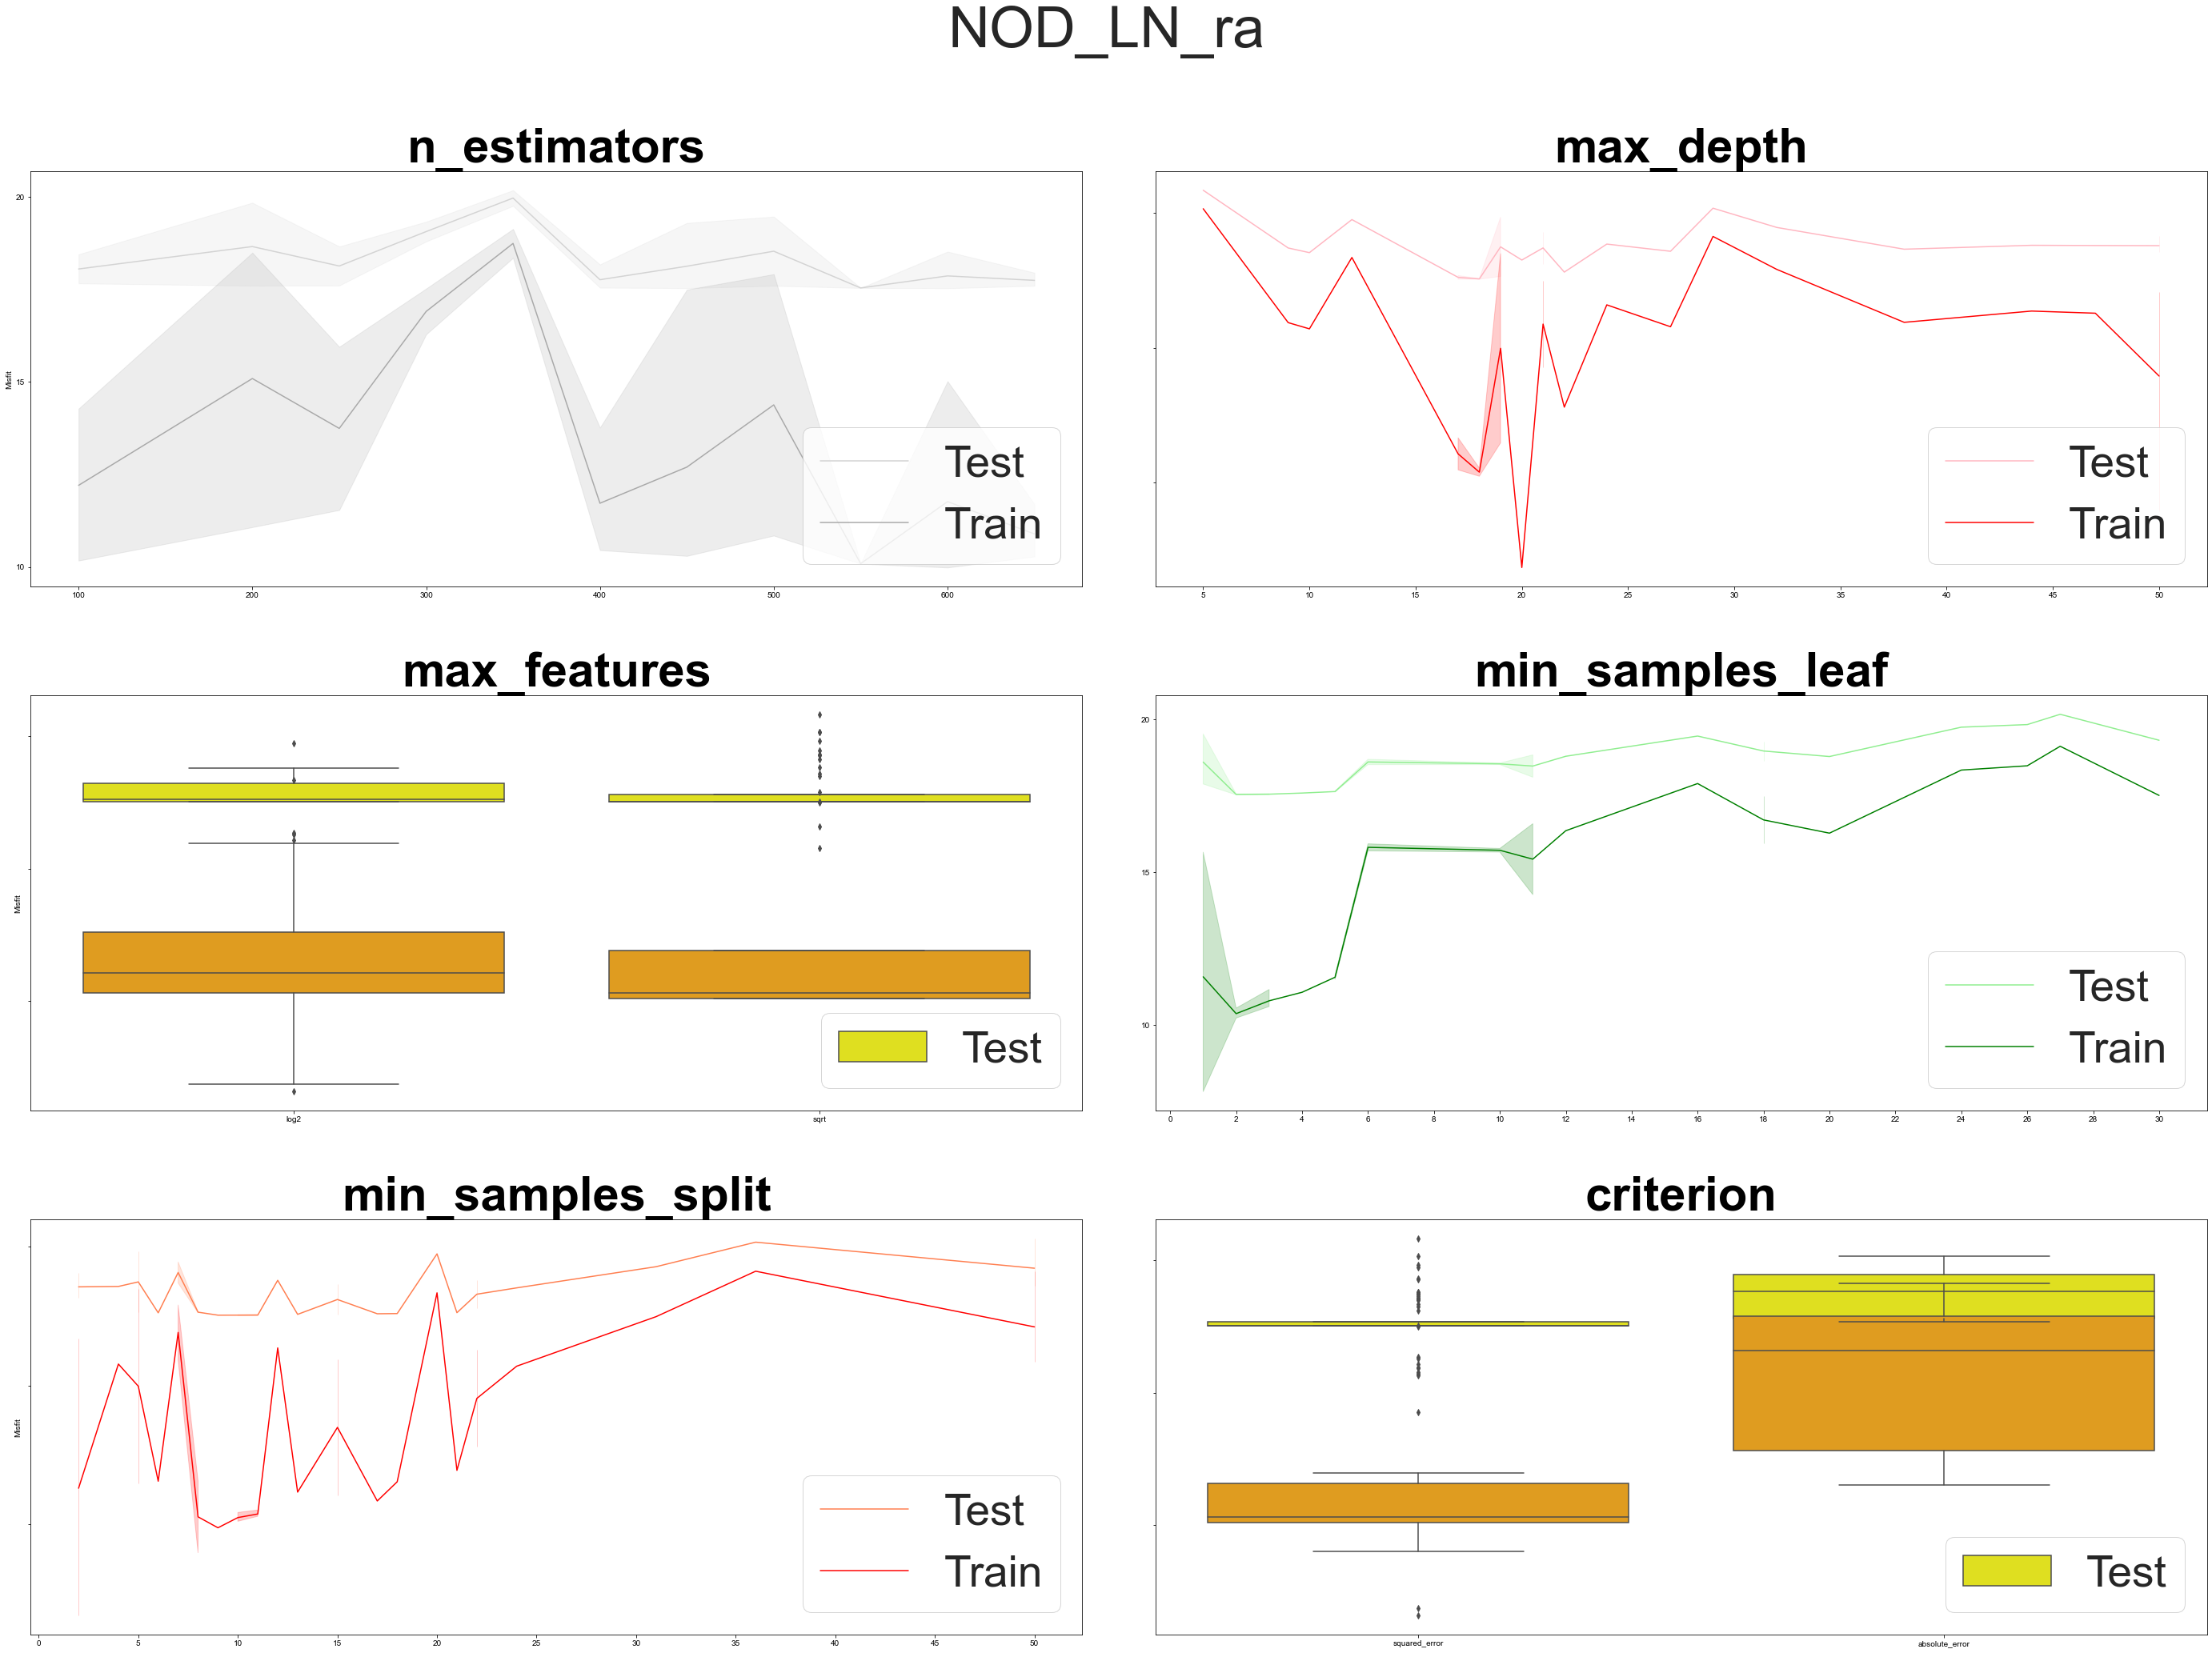

Pramater
n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, criterion 
[650 41 'sqrt' 1 18 'squared_error']
Pramater best top 10
650 39 sqrt 1 21 squared_error
Pramater automatic
650 41 sqrt 1 18 squared_error


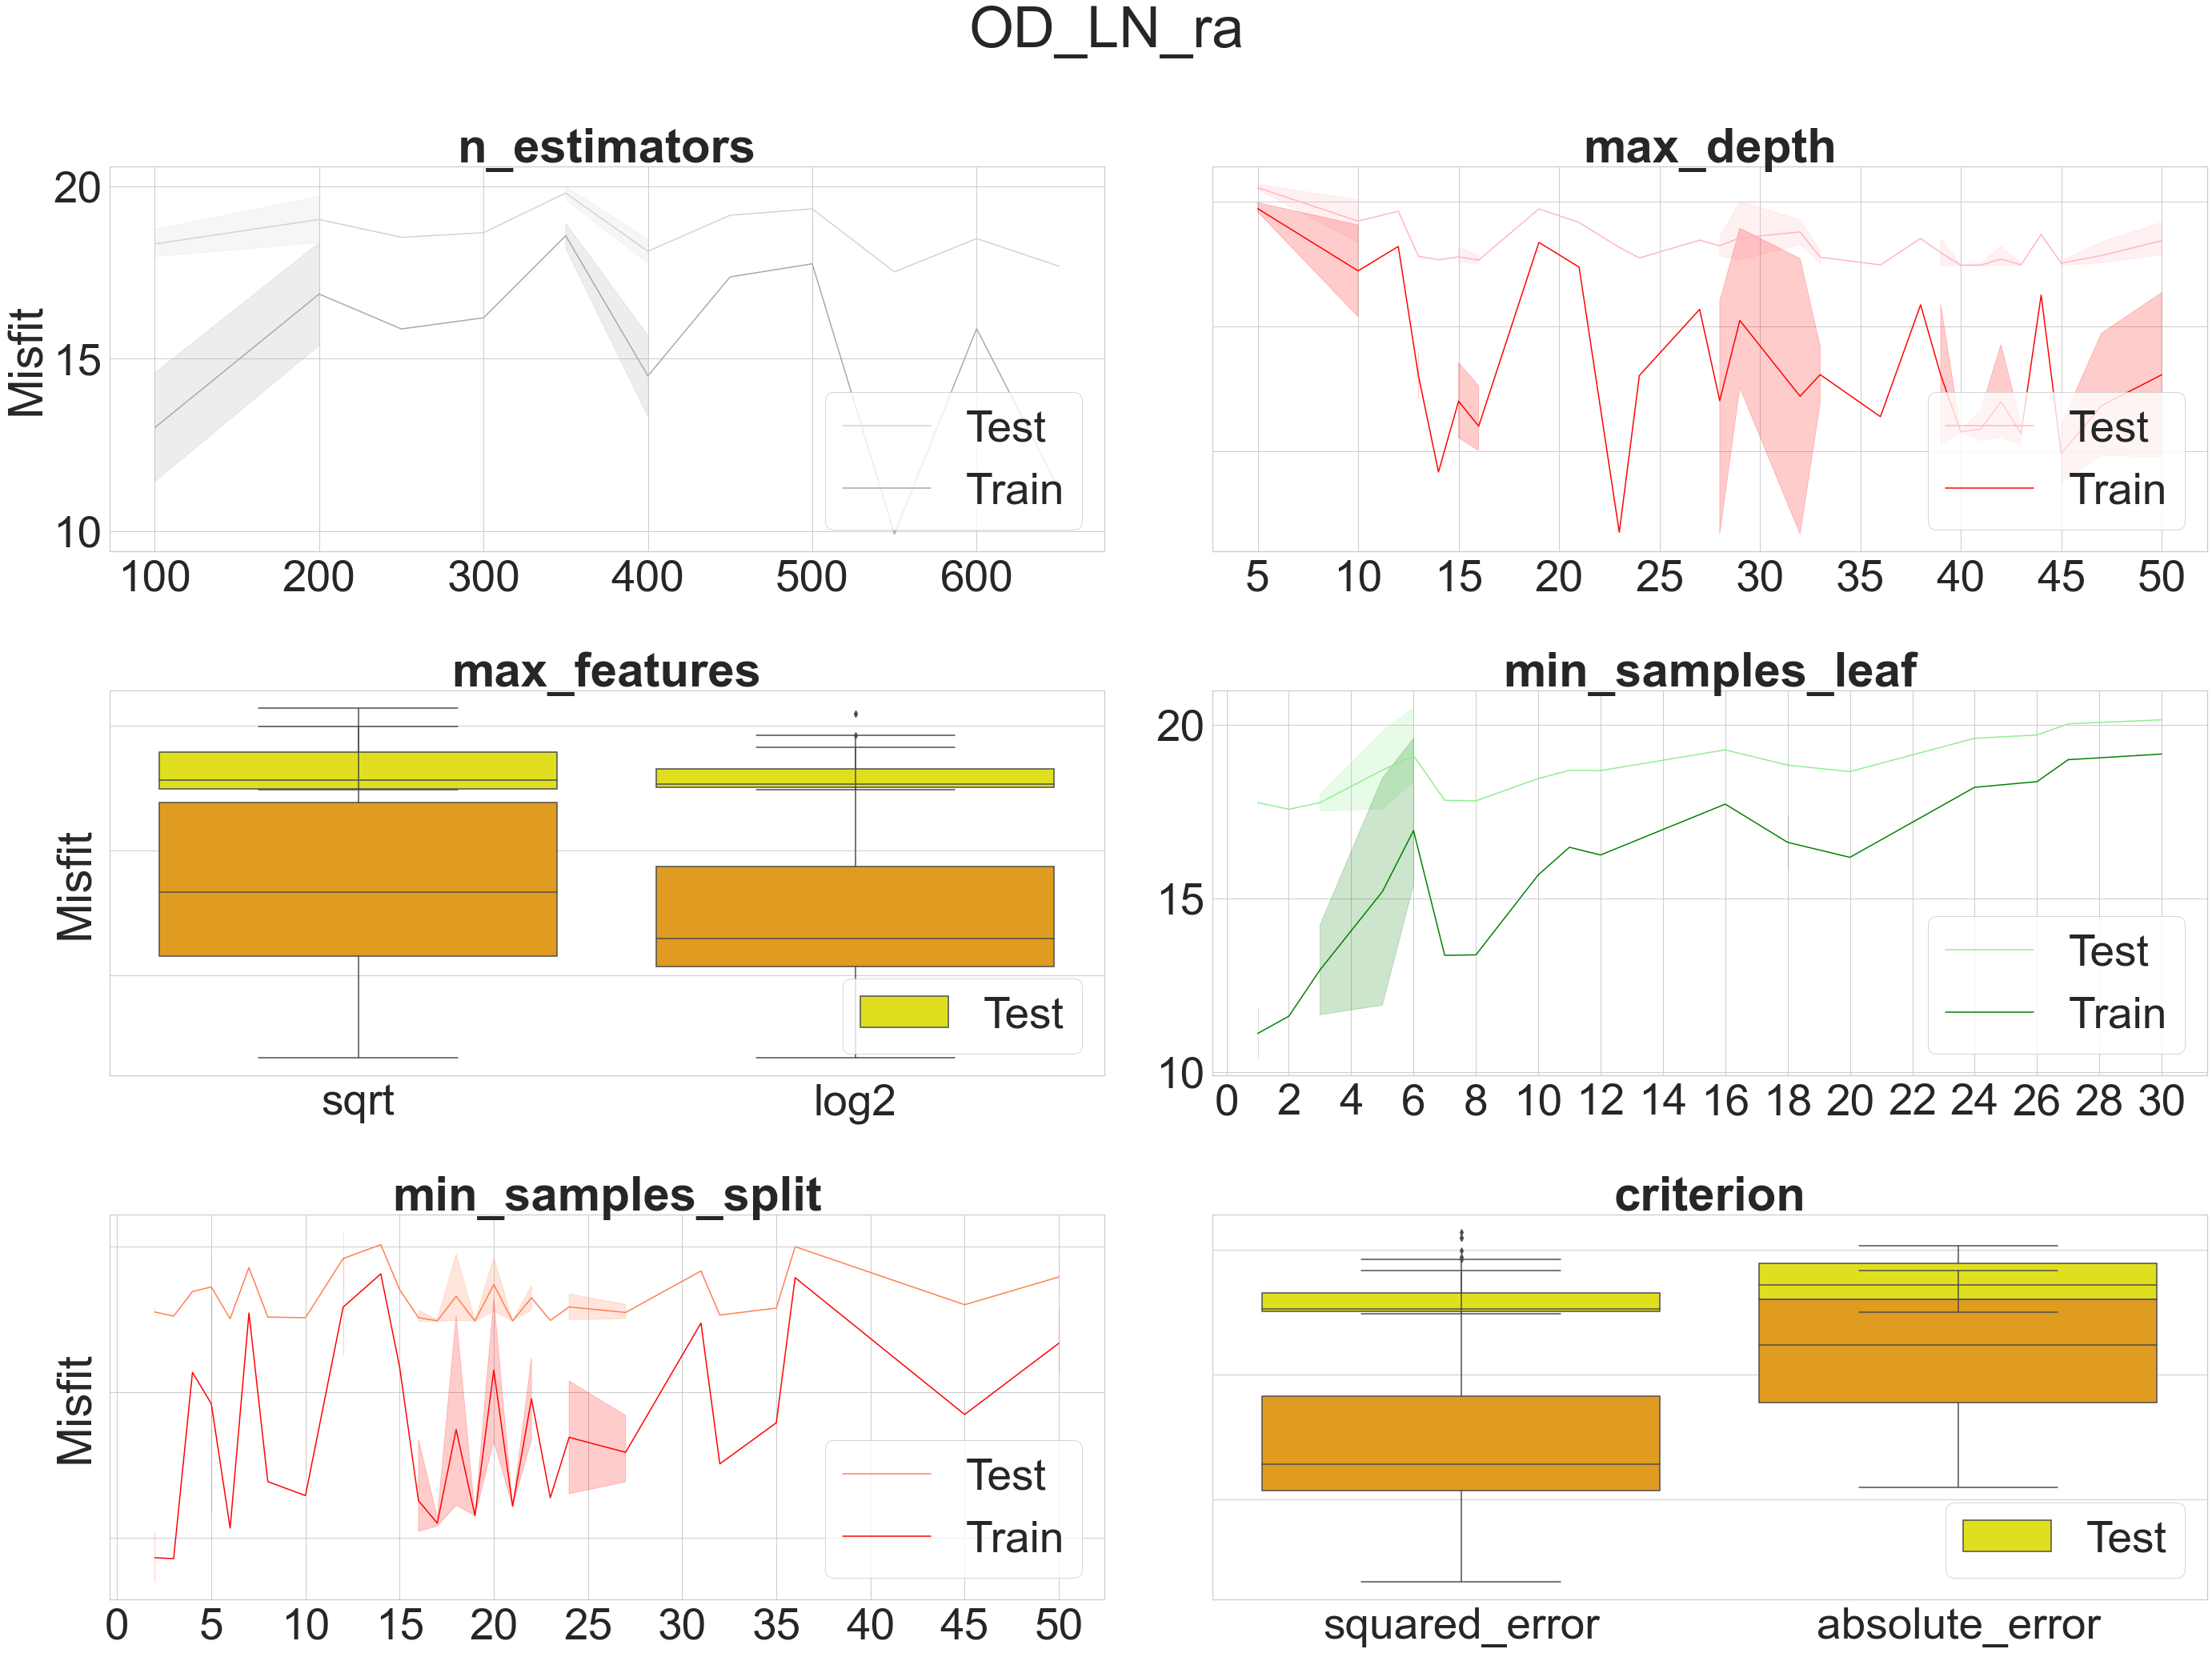

Pramater
n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, criterion 
[650 50 'log2' 5 2 'squared_error']
Pramater best top 10
650 45 log2 5 2 squared_error
Pramater automatic
650 50 log2 5 2 squared_error


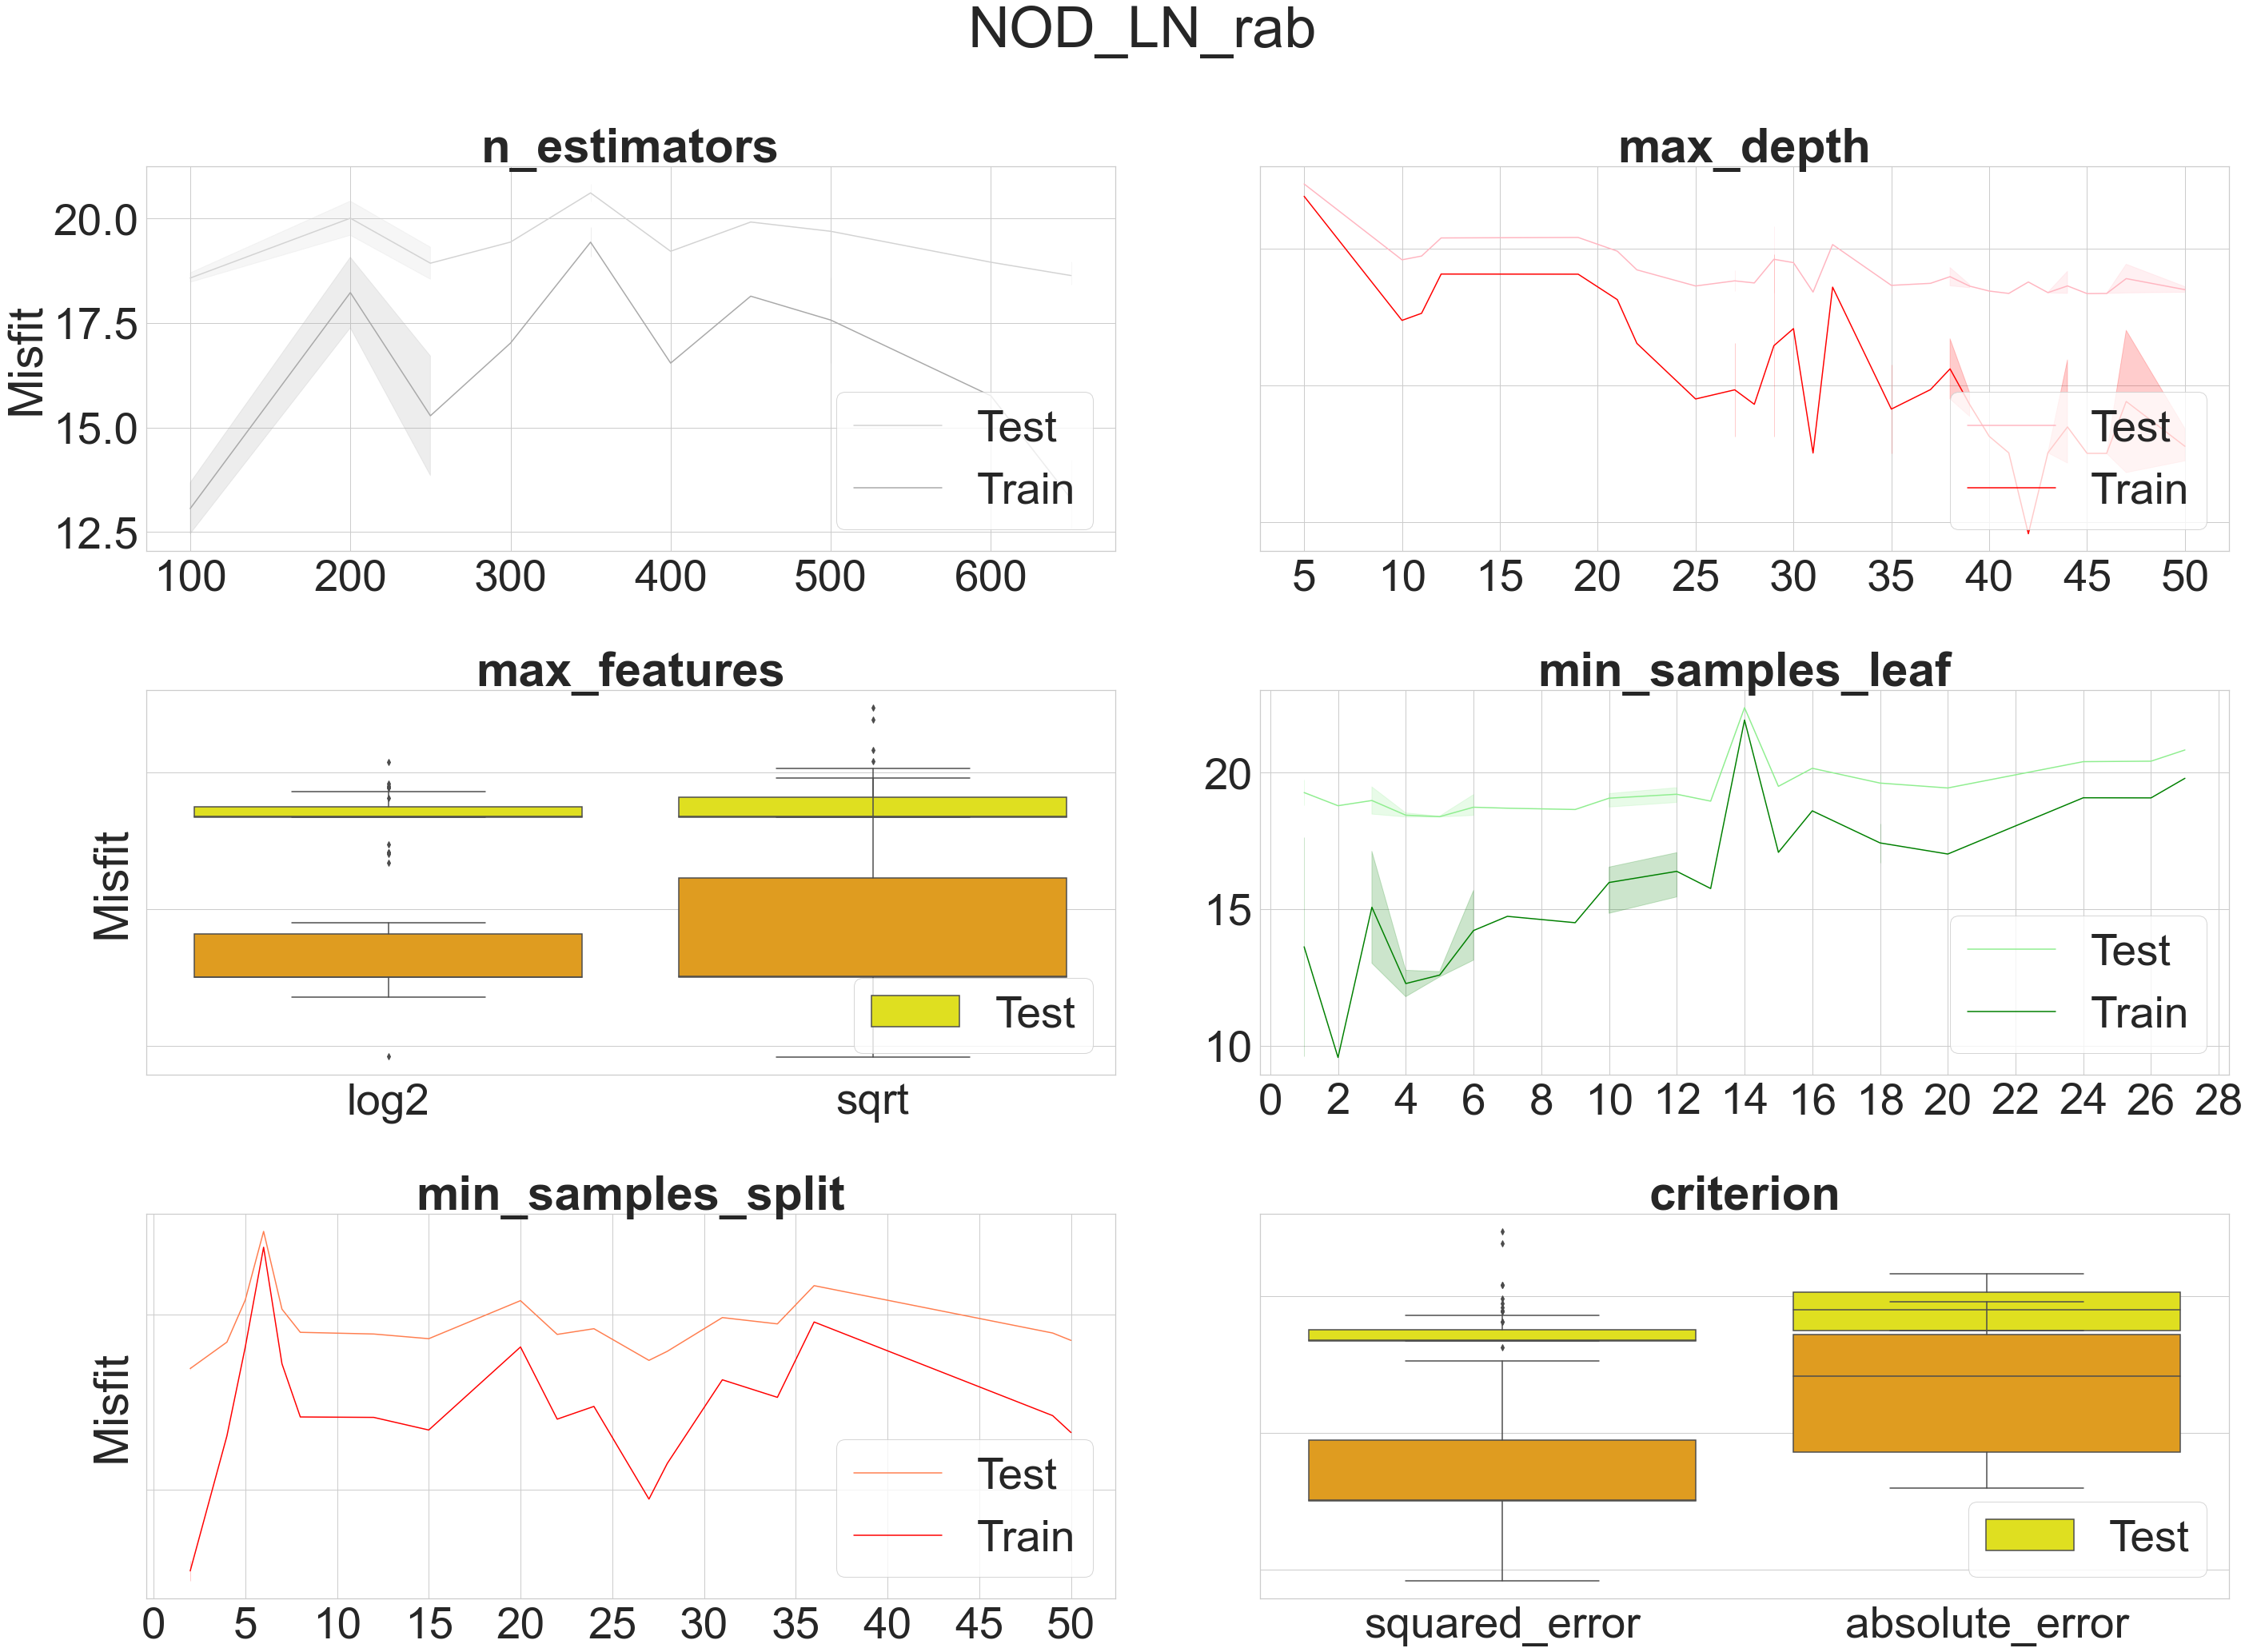

Pramater
n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, criterion 
[650 42 'log2' 1 17 'squared_error']
Pramater best top 10
500 42 log2 2 17 squared_error
Pramater automatic
650 42 log2 1 17 squared_error


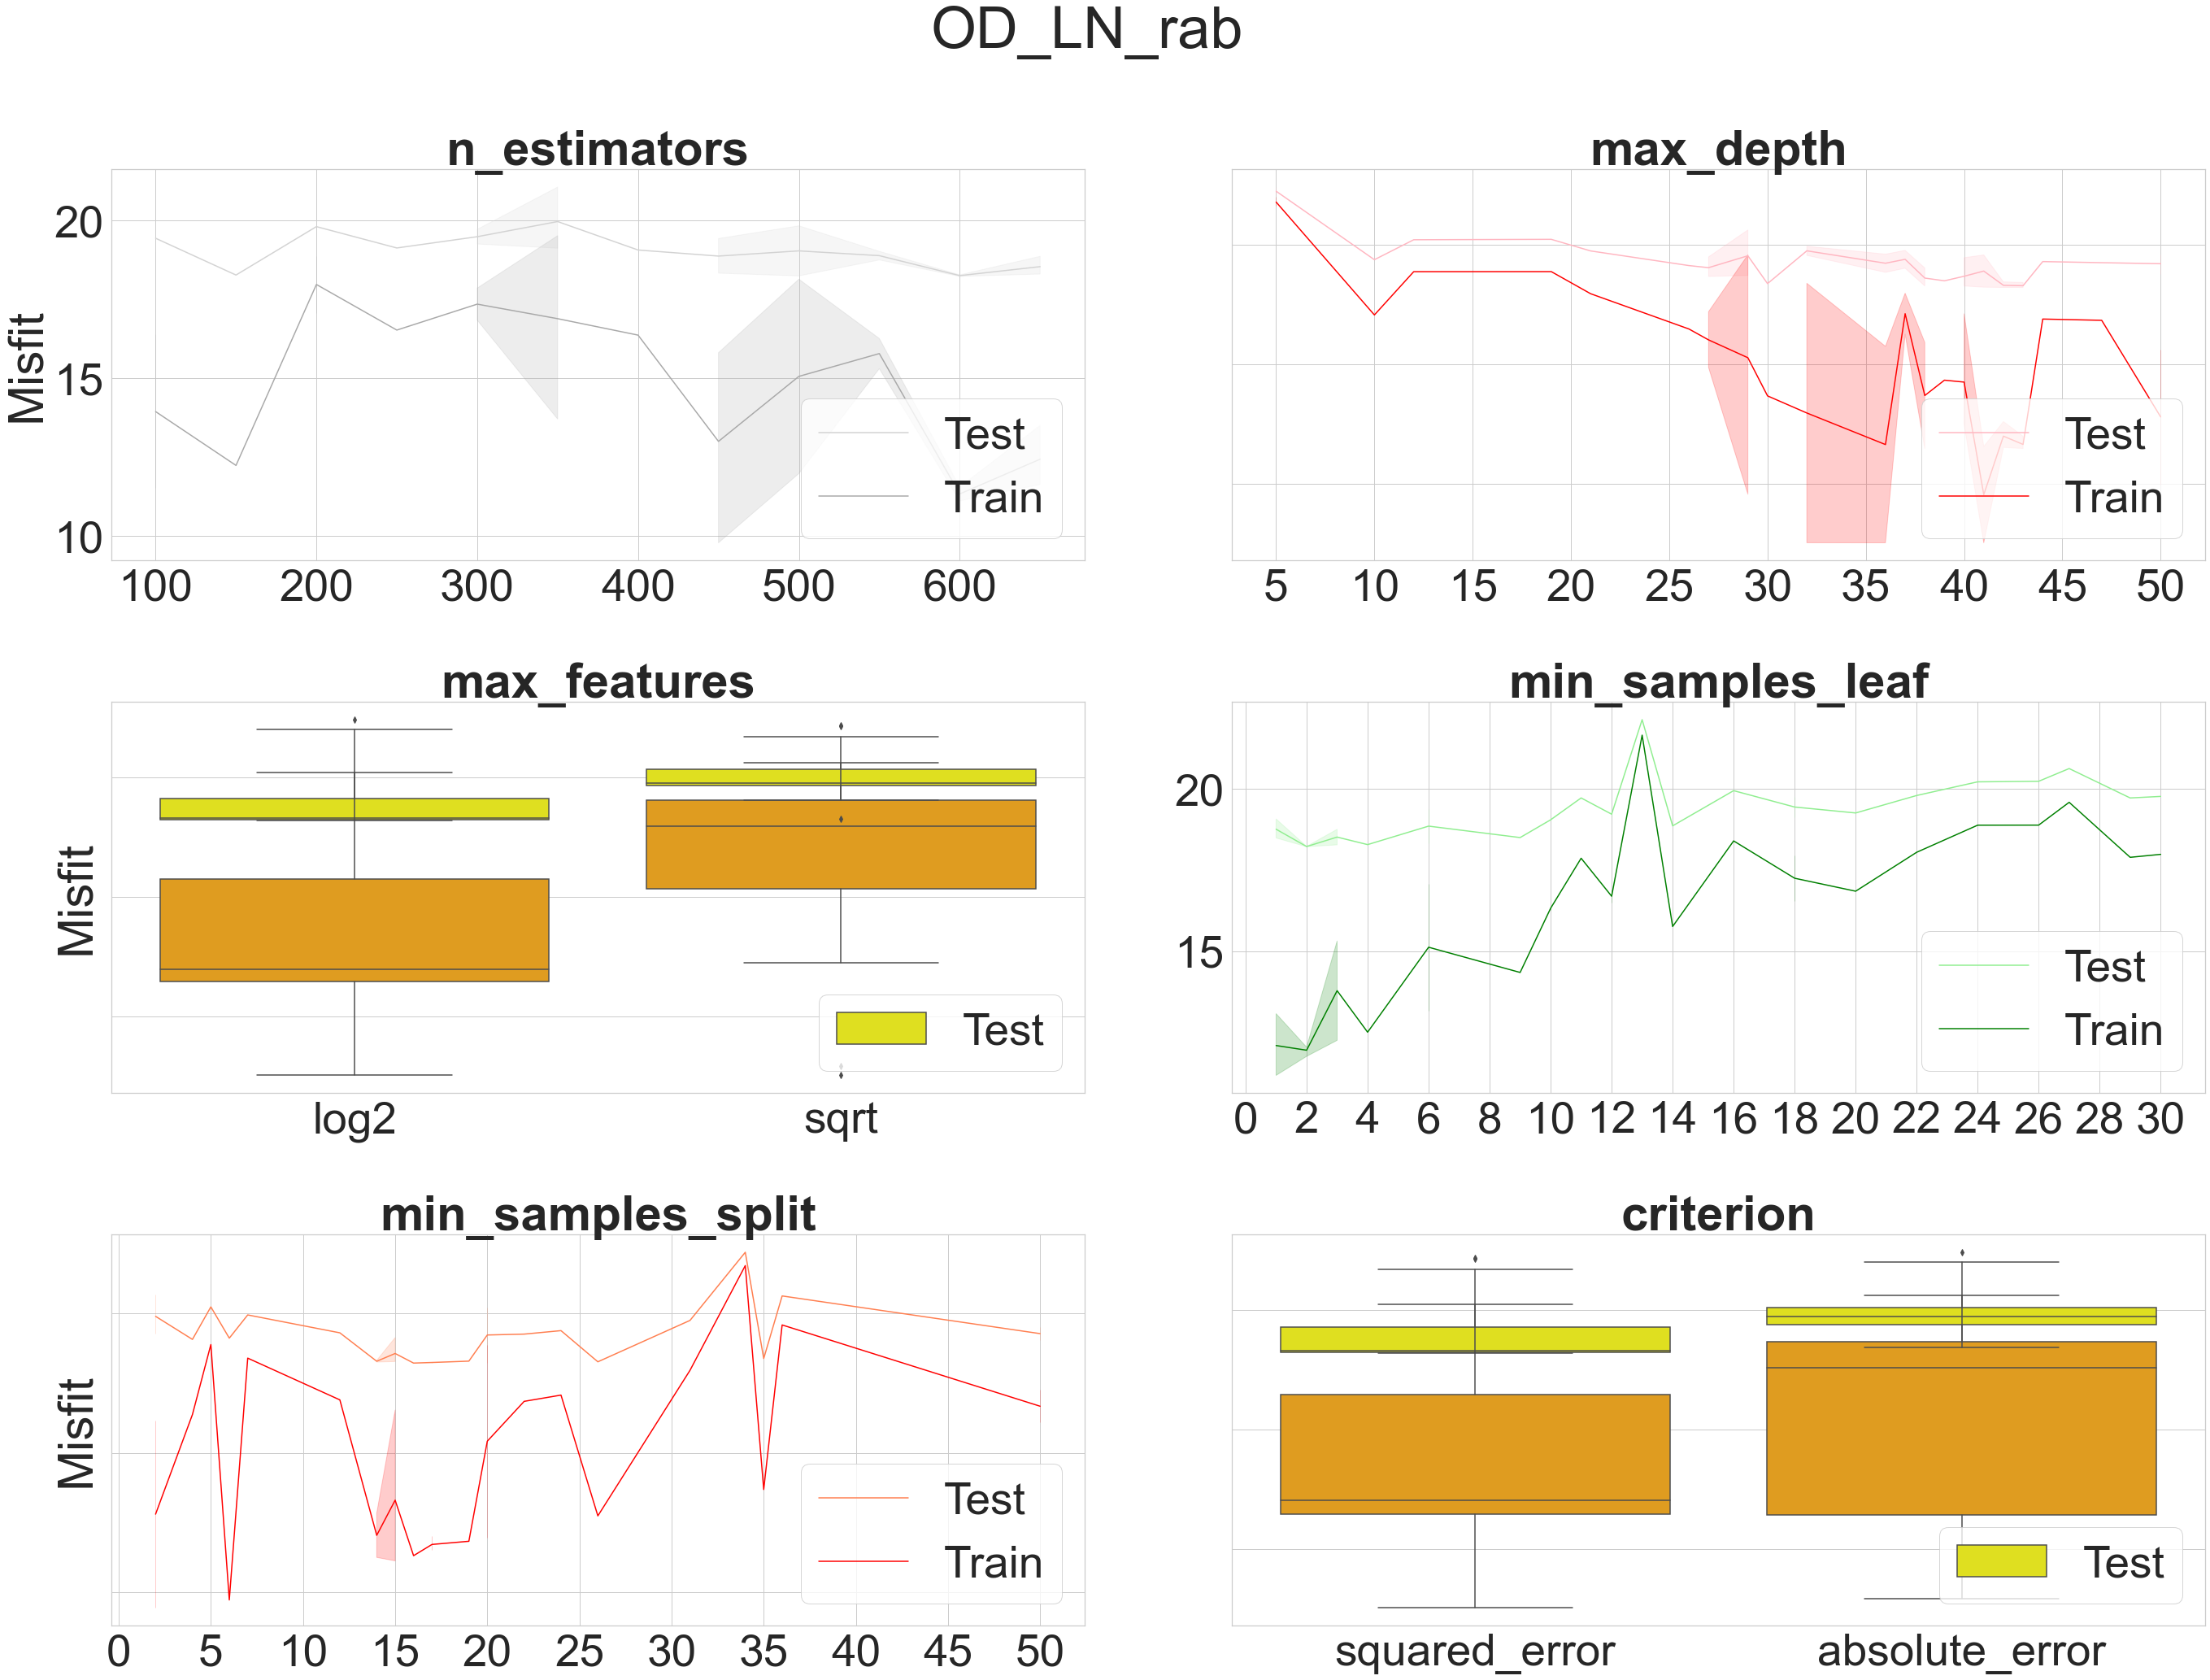

In [9]:
parameter_1 = 'param_regressor__n_estimators'
parameter_2 = 'param_regressor__max_depth'
parameter_3 = 'param_regressor__max_features'
parameter_4 = 'param_regressor__min_samples_leaf'
parameter_5 = 'param_regressor__min_samples_split'
parameter_6 = 'param_regressor__criterion'

file_labels =[ f'NOD_LN_ra', f'OD_LN_ra', 
              f'NOD_LN_rab',  f'OD_LN_rab',]

for file_label in file_labels:
    
    bs_df_i =  dir_p/'RF_Hyperparameters'/f'BS_hyper_{file_label}.csv'
    
    bs_df = pd.read_csv(bs_df_i, sep='\t')

    lower_bound, upper_bound = 0.2,0.8

    fig, axs = plt.subplots(ncols=2, nrows=3)
    sns.set(style="whitegrid", color_codes=True, font_scale = 5)
    fig.set_size_inches(40,30)
    fig.suptitle(file_label)
    
    print('Pramater')
    print('n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, criterion ')
    print(bs_df.loc[0,[parameter_1, parameter_2, parameter_3,parameter_4,parameter_5, parameter_6]].values)
    print('Pramater best top 10')
    print( bs_df.loc[0:10, 'param_regressor__n_estimators'].min(), # should be dec to avoid pure nodes overfit 
           bs_df.loc[0:10, 'param_regressor__max_depth'].min(), # should be dec to avoid pure nodes overfit 
           bs_df.loc[0:10, 'param_regressor__max_features'].mode()[0],
           bs_df.loc[0:10, 'param_regressor__min_samples_leaf'].max(), # should be inc to avoid pure nodes overfit 
           bs_df.loc[0:10, 'param_regressor__min_samples_split'].max(),
           bs_df.loc[0:10, 'param_regressor__criterion'].mode()[0],)
    
    print('Pramater automatic')
    print( bs_df.loc[0, 'param_regressor__n_estimators'], # should be dec to avoid pure nodes overfit 
           bs_df.loc[0, 'param_regressor__max_depth'], # should be dec to avoid pure nodes overfit 
           bs_df.loc[0, 'param_regressor__max_features'],
           bs_df.loc[0, 'param_regressor__min_samples_leaf'], # should be inc to avoid pure nodes overfit 
           bs_df.loc[0, 'param_regressor__min_samples_split'],
           bs_df.loc[0, 'param_regressor__criterion'])

    ######

    sns.lineplot(parameter_1, 'mean_test_score' , data=bs_df, ax=axs[0,0] ,  color='lightgrey', label ='Test',)
    sns.lineplot(parameter_1, 'mean_train_score' , data=bs_df, ax=axs[0,0] , color='darkgrey', label ='Train',)
    #axs[0,0].set(ylim=(lower_bound, upper_bound))
    axs[0,0].set_title(label = f'{parameter_1[17:]}', weight='bold')
    axs[0,0].legend(loc='lower right')
    axs[0,0].set_ylabel('Misfit')
    axs[0,0].set_xlabel('')


    ####

    sns.lineplot(x=parameter_2, y='mean_test_score', data=bs_df, ax=axs[0,1], color='lightpink', label ='Test',)
    sns.lineplot(x=parameter_2, y='mean_train_score', data=bs_df, ax=axs[0,1], color='red' , label ='Train',)
    #axs[0,1].set(ylim=(lower_bound, upper_bound))
    axs[0,1].set_title(label = f'{parameter_2[17:]}', weight='bold')
    axs[0,1].set_ylabel('')
    axs[0,1].set_xlabel('')
    axs[0,1].locator_params(axis='x', nbins=len(bs_df)/6)
    axs[0,1].set(yticklabels=[])  

    axs[0,1].legend(loc='lower right')

    ######
    
        #######
    sns.boxplot(parameter_3, 'mean_test_score' , data=bs_df , ax=axs[1,0], color='yellow', )
    axs[1,0].set_title(label = f'{parameter_3[17:]}', weight='bold')
    sns.boxplot(parameter_3, 'mean_train_score' , data=bs_df , ax=axs[1,0], color='orange', )
    axs[1,0].set_ylabel('Misfit')
    axs[1,0].set_xlabel('')
    axs[1,0].set(yticklabels=[])  
    axs[1,0].legend(axs[1,0].patches, ['Test'], loc='lower right')

    #######


    sns.lineplot(x=parameter_4, y='mean_test_score', data=bs_df, ax=axs[1,1], label ='Test', color='lightgreen')
    sns.lineplot(x=parameter_4, y='mean_train_score', data=bs_df, ax=axs[1,1],label='Train', color='green')
    #axs[1,1].set(ylim=(lower_bound, upper_bound))
    axs[1,1].set_title(label = f'{parameter_4[17:]}', weight='bold')
    axs[1,1].legend(loc='lower right')
    axs[1,1].set_ylabel('')
    axs[1,1].locator_params(axis='x', nbins=len(bs_df)/4)  # set divisor 
    axs[1,1].set_xlabel('')

    ####

    sns.lineplot(x=parameter_5, y='mean_test_score', data=bs_df, ax=axs[2,0], color='coral', label ='Test')
    #axs[2,0].set(ylim=(lower_bound, upper_bound))
    sns.lineplot(x=parameter_5, y='mean_train_score', data=bs_df, ax=axs[2,0], color='red', label='Train')
    axs[2,0].set_title(label = f'{parameter_5[17:]}', weight='bold')
    #axs[1,1].tick_params(labelsize=40) 
    axs[2,0].locator_params(axis='x', nbins=len(bs_df)/6)  # set divisor 
    axs[2,0].set(yticklabels=[])  


 
    axs[2,0].legend(loc='lower right')
    axs[2,0].set_ylabel('Misfit')
    axs[2,0].set_xlabel('')
    ###
    
        #######
    sns.boxplot(parameter_6, 'mean_test_score' , data=bs_df , ax=axs[2,1], color='yellow',  )
    axs[2,1].set_title(label = f'{parameter_6[17:]}', weight='bold')
    sns.boxplot(parameter_6, 'mean_train_score' , data=bs_df , ax=axs[2,1], color='orange', )

    axs[2,1].set_ylabel('')
    axs[2,1].set_xlabel('')
    axs[2,1].set(yticklabels=[])  
    axs[2,1].legend(axs[2,1].patches, ['Test'], loc='lower right')

    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.tight_layout()

    plt.show()